In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from itertools import product
from multiprocessing import Pool
from pprint import pprint

## Generating random networks

### types of random network

![types of random networks](./attachments/networkx_random_vs_scalefree_smallworld.jpg)

### Random network (Erdos Renyi)

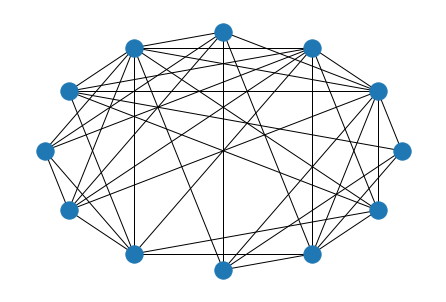

In [2]:
G1 = nx.erdos_renyi_graph(n=12, p=0.5)
nx.draw_circular(G1)

### Small World network (Watts Strogatz)

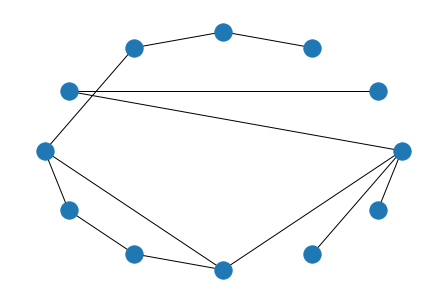

In [3]:
G2 = nx.watts_strogatz_graph(n=12, k=2 , p=1/2)
nx.draw_circular(G2)

### Random network (Barabasi Albert)

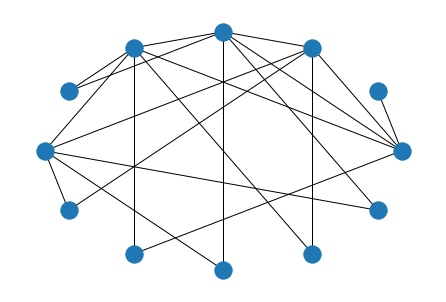

In [4]:
G3 = nx.barabasi_albert_graph(n=12, m=2)
nx.draw_circular(G3)

## Network metrics

In [5]:
def network_metrics(G):
    avg_degree = 2*G.number_of_edges() / float(G.number_of_nodes())
    count = 0
    avg_dist = 0
    for component in nx.connected_components(G):
        g = G.subgraph(component)
        count += 1
        avg_dist += nx.average_shortest_path_length(g)
    avg_dist /= count
    nb_components = len(list(nx.connected_components(G)))
    return {'nb components': np.round(count, 2),
            'avg degree' : np.round(avg_degree, 2),
            'avg distance' : np.round(avg_dist, 2),
            'degree distribution': np.array(nx.degree_histogram(G)),
        }

In [6]:
for G in [G1, G2, G3]:
    pprint(network_metrics(G))
    print("\n")

{'avg degree': 6.5,
 'avg distance': 1.42,
 'degree distribution': array([0, 0, 0, 0, 1, 2, 4, 2, 1, 2]),
 'nb components': 1}


{'avg degree': 2.0,
 'avg distance': 3.05,
 'degree distribution': array([0, 4, 5, 2, 1]),
 'nb components': 1}


{'avg degree': 3.33,
 'avg distance': 1.88,
 'degree distribution': array([0, 1, 6, 0, 0, 3, 2]),
 'nb components': 1}




## Generating random network with similar metrics

Generating different types of network given an expected average node degree

### Helper functions

In [7]:
def avg_degree_to_erdos_renyi_kwargs(nb_nodes, avg_degree):
    """Convert parameters to usable inputs for networkx.erdos_renyi_graph()
    
    Args:
        nb_nodes (int):     number of nodes
        avg_degree (float): expected average degree of the graph
    
    Returns:
        dict(          keyword arguments
            n (int):   number of nodes
            p (float): edge probability (in [0,1])
        )
    """
    edge_probability = avg_degree / nb_nodes
    return {'n': nb_nodes, 'p' : edge_probability}

In [8]:
def avg_degree_to_watts_strogatz_kwargs(nb_nodes, avg_degree, rewiring_probability):
    """Convert parameters to usable inputs for networkx.watts_strogatz_graph()
    
    Args:
        nb_nodes (int):               number of nodes
        avg_degree (float):           expected average degree of the graph
        rewiring_probability (float): rewiring probability (in [0,1])
    
    Returns:
        dict(          keyword arguments
            n (int):   number of nodes
            k (int):   initial number of neighbors
            p (float): rewiring probability (in [0,1])
        )
    """
    nb_neighbours = round(avg_degree)
    return {'n': nb_nodes, 'k': nb_neighbours , 'p': rewiring_probability}

In [9]:
def avg_degree_to_barabasi_albert_kwargs(nb_nodes, avg_degree):
    """Convert parameters to usable inputs for networkx.barabasi_albert_graph()
    
    Args:
        nb_nodes (int):     number of nodes
        avg_degree (float): expected average degree of the graph
    
    Returns:
        dict(          keyword arguments
            n (int):   number of nodes
            m (int):   initial clique
        )
    """
    if not is_valid_BA_params(nb_nodes, avg_degree):
        raise ValueError(f"barabasi_albert_graph():"
                f"expected average degree ({avg_degree}) is too low"
                f"compared to the number of nodes ({nb_nodes}).")
    nb_neighbours = BA_initial_clique_from_avg_degree(nb_nodes, avg_degree)
    return {'n': nb_nodes, 'm': nb_neighbours}


def is_valid_BA_params(n, avg_degree):
    """Check if necessary conditions are met for generating a Barabasi Albert graph.
    See annex (end of notebook) for more details about the explanation.
    
    Args:
        n (int):             number of nodes
        avg_degree (float):  expected average degree of the graph
    
    Returns:
        bool: valid parameters
    """
    return avg_degree <= n**2 / (2*(n+1))


def BA_initial_clique_from_avg_degree(n, avg_degree):
    """Generate the initial clique value (m) inputs for networkx.barabasi_albert_graph().
    See annex (end of notebook) for more details about the explanation.
    
    Args:
        n (int):            number of nodes
        avg_degree (float): expected average degree of the graph
    
    Returns:
        int:   initial clique (m)
    """
    return round(np.min(np.roots([2/(n+1), 2/(n+1)-2, avg_degree])))

In [10]:
def generate_random_graph(network_type, nb_nodes, avg_degree):
    graph = {
        'random': {
            'generator': nx.erdos_renyi_graph,
            'param': avg_degree_to_erdos_renyi_kwargs(nb_nodes, avg_degree),
            },
        'small world': {
            'generator': nx.watts_strogatz_graph,
            'param': avg_degree_to_watts_strogatz_kwargs(nb_nodes, avg_degree, 0.5),
            },
        'scale free': {
            'generator': nx.barabasi_albert_graph,
            'param': avg_degree_to_barabasi_albert_kwargs(nb_nodes, avg_degree),
            }, 
    }
    return graph[network_type]['generator'](**graph[network_type]['param'])

### Generating network metadata

for a fixed `(n, avg_degree)` parameters

{'avg degree': 8.14,
 'avg distance': 2.42,
 'degree distribution': array([ 0,  0,  2,  2,  6, 11, 14,  9, 15, 10, 10,  5,  5,  7,  1,  2,  0,
        0,  1]),
 'nb components': 1}


{'avg degree': 8.0,
 'avg distance': 2.48,
 'degree distribution': array([ 0,  0,  0,  0,  0,  4, 10, 26, 24, 20, 12,  3,  0,  1]),
 'nb components': 1}


{'avg degree': 7.68,
 'avg distance': 2.34,
 'degree distribution': array([ 0,  0,  0,  0, 40, 12, 11,  6,  5,  5,  4,  2,  2,  2,  1,  2,  2,
        0,  0,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  1,  0,  1]),
 'nb components': 1}




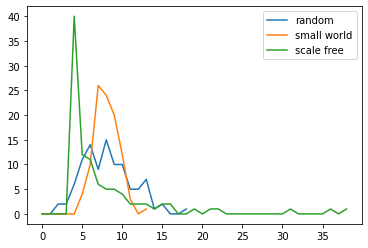

In [11]:
n = 100
avg_degree = 8
network_types = ['random', 'small world', 'scale free']

for option in network_types:
    G = generate_random_graph(option, n, avg_degree)
    pprint(network_metrics(G))   # show network metrics for each type of graph
    plt.plot(network_metrics(G)['degree distribution'], label=option)  # show degree distribution
    print("\n")
    
plt.legend(loc="upper right")

<br>

for a multiple `(n, avg_degree)` parameters

In [12]:
def generate_graph_metadata(nx_type, N, k):
    dct = {'graph_type': nx_type, 'nb_nodes': N, 'expected_avg_degree': k}
    G = generate_random_graph(nx_type, N, k)
    dct.update(network_metrics(G))
    return dct

In [13]:
network_types = ['random', 'small world', 'scale free']
nb_nodes = [100, 200]
expected_avg_degree = np.arange(2,31,1).tolist()

# generate all possible combination of above parameters
settings = list(product(network_types, nb_nodes, expected_avg_degree))

In [14]:
# (multiprocessing) generate graph metadata for all settings
p = Pool()
result = p.starmap(generate_graph_metadata, settings)
p.close()
p.join()

### Storing network metadata

as a `pandas.DataFrame`

In [15]:
df = pd.DataFrame(result)
df

,graph_type,nb_nodes,expected_avg_degree,nb components,avg degree,avg distance,degree distribution
0,random,100,2,18,1.90,0.51,"[15, 26, 29, 18, 10, 0, 2]"
1,random,100,3,6,2.78,0.73,"[5, 19, 29, 21, 8, 7, 7, 3, 1]"
2,random,100,4,2,3.80,1.76,"[1, 7, 15, 21, 26, 14, 9, 4, 3]"
3,random,100,5,1,4.94,3.02,"[0, 3, 12, 10, 18, 20, 17, 6, 10, 2, 0, 1, 1]"
4,random,100,6,1,5.70,2.80,"[0, 1, 3, 8, 21, 14, 19, 16, 10, 3, 4, 0, 1]"
...,...,...,...,...,...,...,...
256,scale free,500,26,1,25.32,2.19,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 66, 54..."
257,scale free,500,27,1,27.22,2.15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 56,..."
258,scale free,500,28,1,27.22,2.16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 55,..."
259,scale free,500,29,1,29.10,2.12,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


<br>

as a `xarray.Dataset`

In [18]:
ds = df.set_index(['graph_type', 'nb_nodes', 'expected_avg_degree']).to_xarray()
ds

<xarray.Dataset>
Dimensions:              (graph_type: 3, nb_nodes: 3, expected_avg_degree: 29)
Coordinates:
  * graph_type           (graph_type) object 'random' 'scale free' 'small world'
  * nb_nodes             (nb_nodes) int64 100 200 500
  * expected_avg_degree  (expected_avg_degree) int64 2 3 4 5 6 ... 27 28 29 30
Data variables:
    nb components        (graph_type, nb_nodes, expected_avg_degree) int64 18...
    avg degree           (graph_type, nb_nodes, expected_avg_degree) float64 ...
    avg distance         (graph_type, nb_nodes, expected_avg_degree) float64 ...
    degree distribution  (graph_type, nb_nodes, expected_avg_degree) object [...

## Comparing metrics

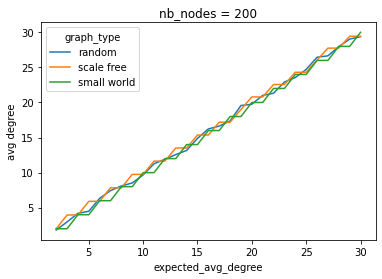

In [60]:
# Actual average degree 
n = 200
da = ds.sel(nb_nodes=n)['avg degree']
da.plot(x="expected_avg_degree", hue="graph_type")

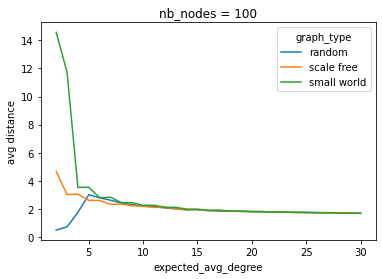

In [62]:
# Actual average distance 
n = 100
da = ds.sel(nb_nodes=n)['avg distance']
da.plot(x="expected_avg_degree", hue="graph_type")

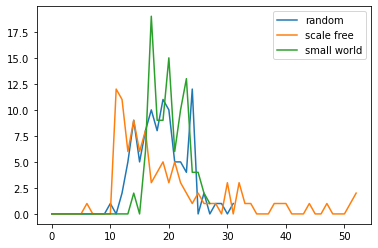

In [63]:
# Degree distribution
n = 100
k = 20

for i, label in enumerate(ds.graph_type.values):
    da = ds.sel(nb_nodes=n, expected_avg_degree=k)['degree distribution']
    plt.plot(da.values[i], label=label)
plt.legend(loc="upper right")

## Annex

The **`nx.barabasi_albert_graph()`** requires 2 parameters:
- **`n`**: the number of nodes,
- **`m`**: the initial number of connections

For a given number of nodes **`N`** and an expected average degree **`<k>`**, we can determine **`m`** with the following formula: 

$$\begin{align}
    <k> &= \sum_{k=m}^N ip_i                        && \text{average degree formula}\\
    &= \sum_{i=m}^N i \frac{2m(m+1)}{i(i+1)(i+2)}   &&\text{see Barabasi}\\
    &= \sum_{i=m}^N \frac{2m(m+1)}{(i+1)(i+2)} \\
    &= \sum_{i=m}^N \left(\frac{2m(m+1)}{i+1} - \frac{2m(m+1)}{i+2}\right) \\
    &= \sum_{i=m}^N \frac{2m(m+1)}{i+1} - \sum_{i=m}^N \frac{2m(m+1)}{i+2} \\
    &= \sum_{i=m}^N \frac{2m(m+1)}{i+1} - \sum_{j=m+1}^{N+1} \frac{2m(m+1)}{j+1}  &&\text{replacing by } j = i+1 \\
    &= \frac{2m(m+1)}{m+1} - \frac{2m(m+1)}{N+1}    &&\text{simplifying telescoping elements}\\
    &= 2m - \frac{2m(m+1)}{N+1}                     \tag 1 \\
\end{align}$$


  
Hence for a given **`N`** and **`<k>`**, the initial **`m-clique`** are the polynomial root of:

$$\begin{align}
    \frac{2}{N+1} &m^2 + \left(\frac{2}{N+1} -2 \right)m + k = 0 && \text{(using }k \text{ instead of } <k> \text{)} \\
    \Rightarrow &m = \frac{N}{2} \pm \frac{\sqrt{N^2 - 2Nk - 2k}}{2}  \\
    \Rightarrow &m = \frac{N}{2} - \frac{\sqrt{N^2 - 2Nk - 2k}}{2} &&\text{since } m \le N \tag 2\\
\end{align}$$


<br>  
But working with real numbers also implies:

$$\begin{align}
    0 &\le N^2 - 2Nk - 2k \\
    \Rightarrow k &\le \frac{N^2}{2(N+1)}  \tag 3\\
\end{align}$$